## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
!cat requirements.txt

python-binance==1.0.16
mplfinance==0.12.9b0
tensorflow==2.8.2
pydot==1.3.0
graphviz==0.10.1
scikit-learn==1.0.2
backtrader==1.9.76.123
pyfolio-reloaded==0.9.3

In [3]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 70 kB 7.9 MB/s 
     |████████████████████████████████| 410 kB 56.1 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 288 kB 38.8 MB/s 
     |████████████████████████████████| 112 kB 54.0 MB/s 
     |████████████████████████████████| 355 kB 51.0 MB/s 
     |████████████████████████████████| 1.6 MB 40.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 749 kB 52.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [4]:
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
from pathlib import Path
import csv

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [5]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [6]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [7]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [8]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [9]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [10]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (177732, 8)


In [11]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:00:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:15:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:30:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:45:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:00:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1663398000,1663398000,19840.72,19863.45,19828.03,19829.71,1382.851930,29878.0,2022-09-17 07:00:00,2022-09-17 07:15:00
1663398900,1663398900,19829.71,19846.68,19819.04,19824.58,1399.331340,30073.0,2022-09-17 07:15:00,2022-09-17 07:30:00
1663399800,1663399800,19825.33,19843.00,19819.81,19821.50,1428.765140,30128.0,2022-09-17 07:30:00,2022-09-17 07:45:00


### Plot wick Candles and build features from technical analysis

In [12]:
can_btc = fb.Candles(ldata_df,"Bitcoin", target = "LogReturns")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:15:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:30:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:45:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:00:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-09-17 07:00:00,19828.03,19863.45,19840.72,19829.71,1382.851930
2022-09-17 07:15:00,19819.04,19846.68,19829.71,19824.58,1399.331340
2022-09-17 07:30:00,19819.81,19843.00,19825.33,19821.50,1428.765140


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


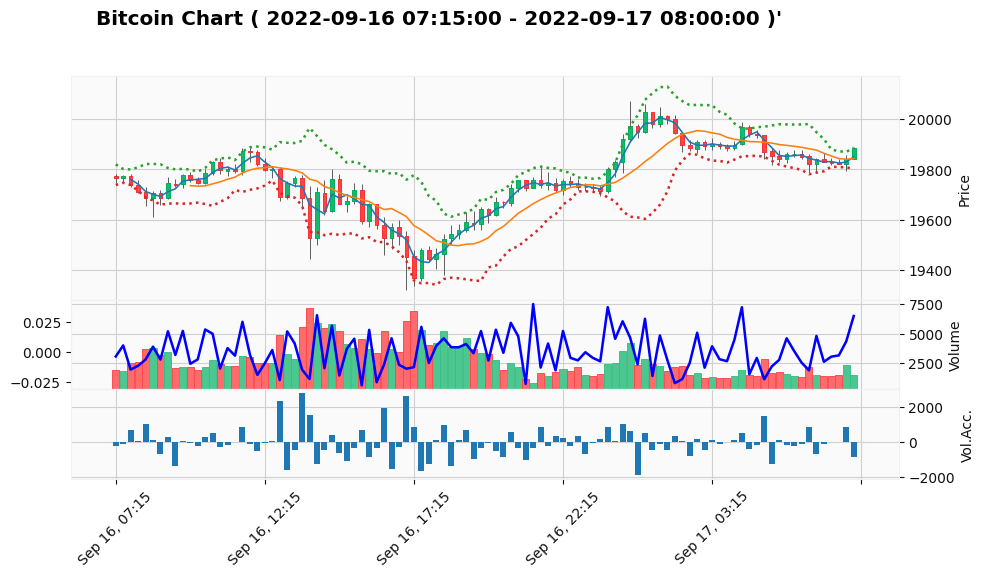

In [13]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [14]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, target = "LogReturns", 
                                laststeps = 50000, step_back = 48, candle_step_str = "15m",
                                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 10)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [15]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.scaler
ts_btc.y[-10:]

[0.0008921283493332766,
 7.401441874677062e-05,
 -0.0005514635200594142,
 -0.0015603494012044195,
 0.0010020291043559837,
 -0.0005036626564987046,
 -0.0002587361936683408,
 -0.00015537475615268193,
 0.0010382318821644532,
 0.0021884011437123263]

## Train a CNN-LSTM model 

In [16]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.9)

In [17]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 48, 10)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       992         ['candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2272        ['candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       4192        ['candles[0][0]']                
                                                                                              

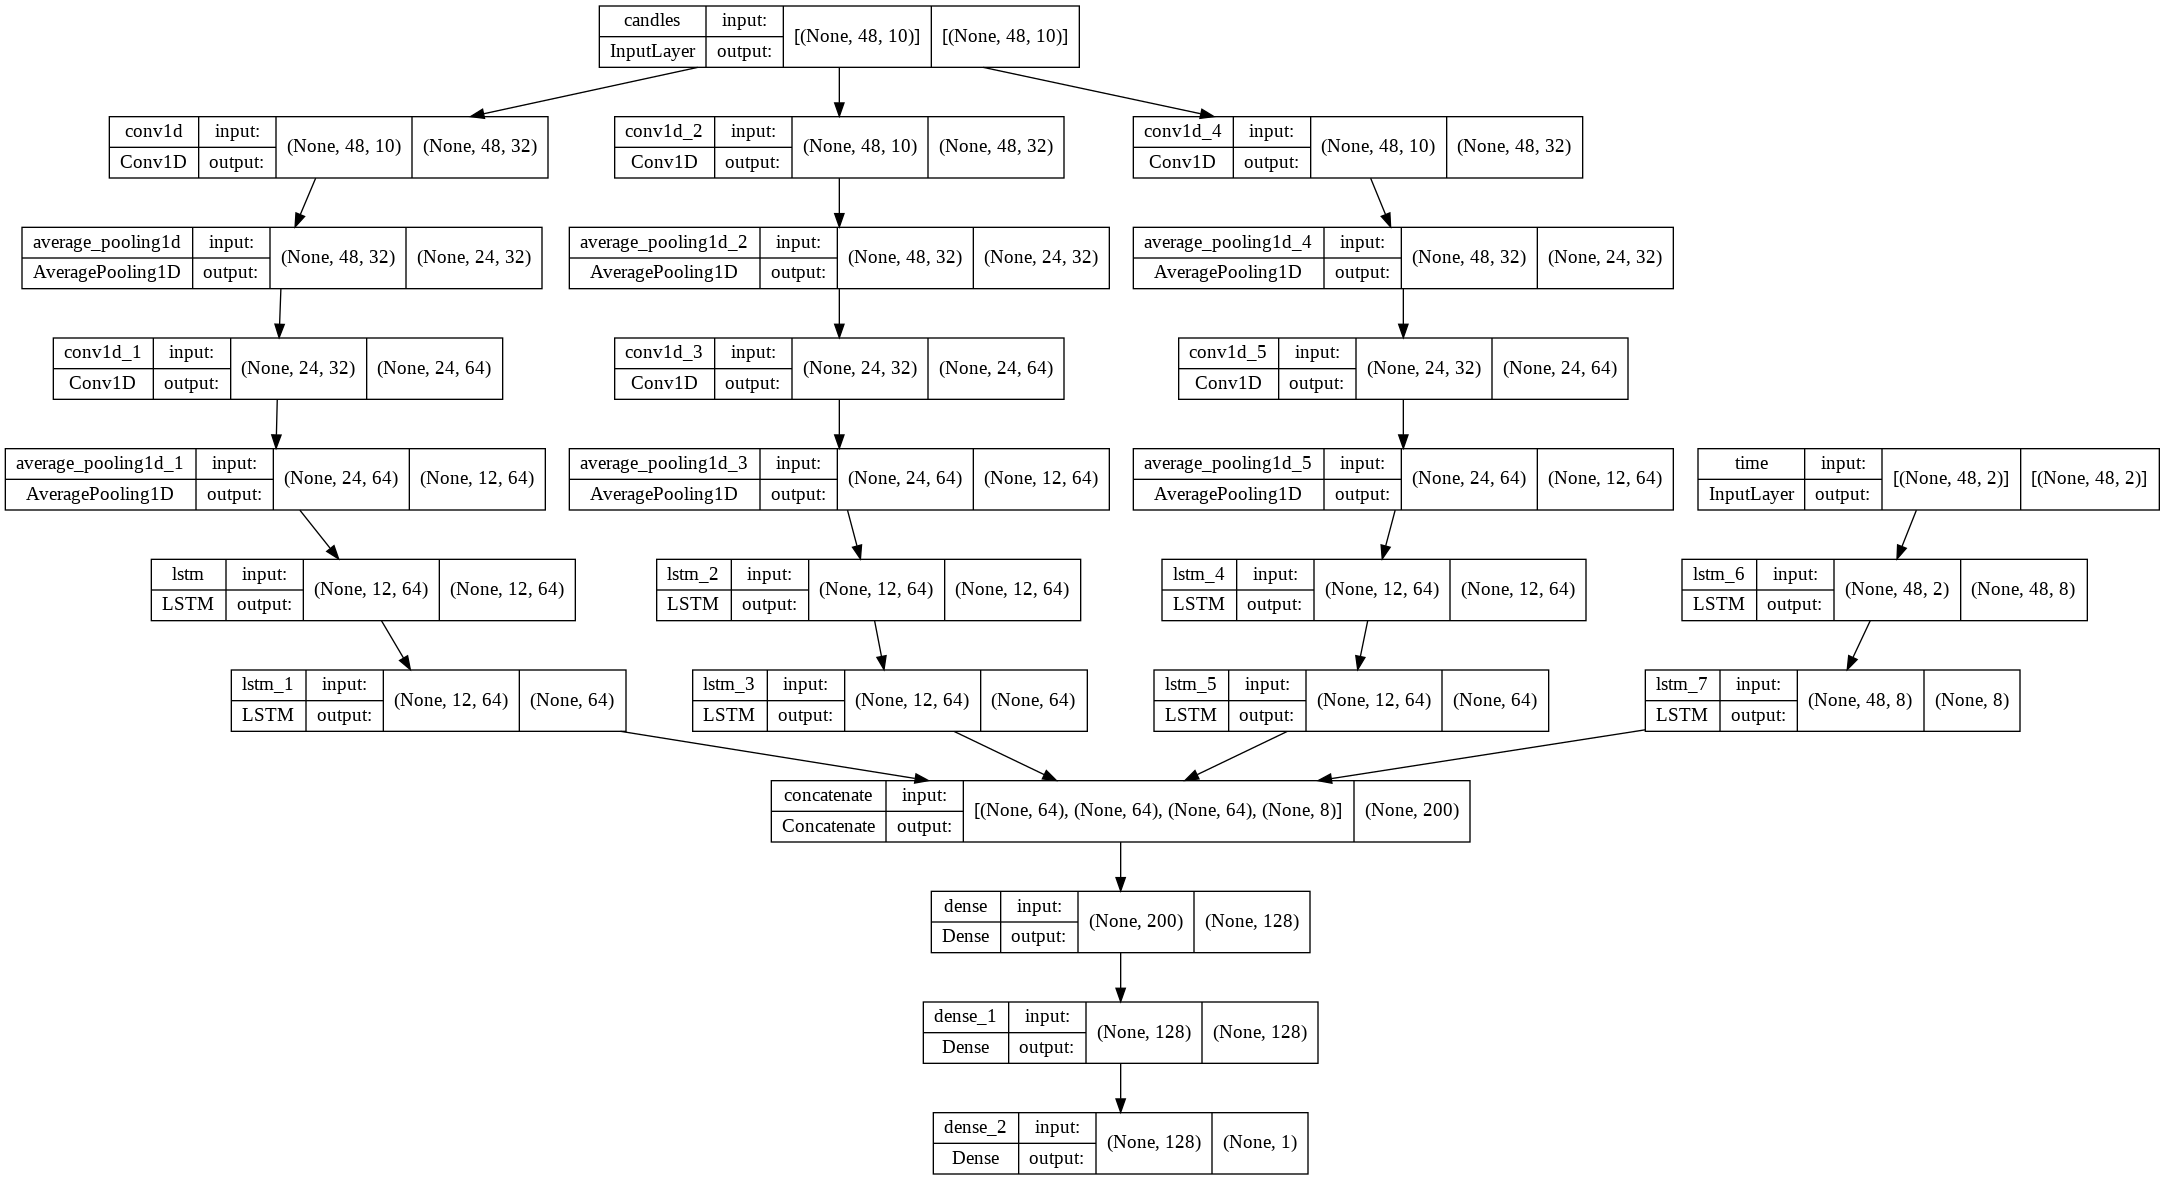

In [18]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [19]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name,save_model = False)

Epoch 1/20
11/11 [==============================] - 31s 516ms/step - loss: 0.0229 - val_loss: 0.0073
Epoch 2/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 3/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 4/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 5/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/20
11/11 [==============================] - 1s 100ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 9/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0027 - val_loss: 0.0020

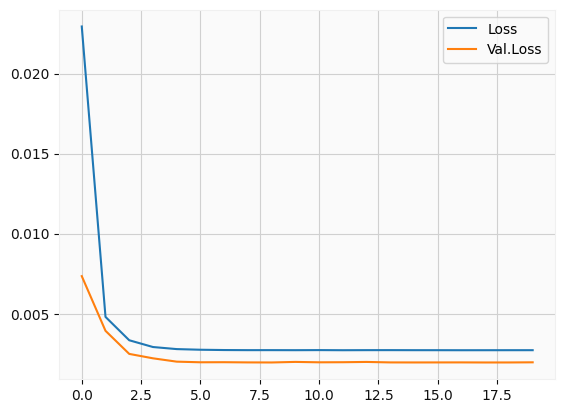

In [20]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [21]:
btc_model.sats2pred(predict_on_test = True)

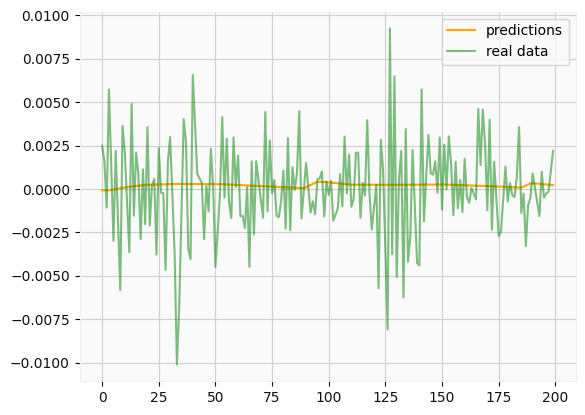

In [22]:
plt.plot(btc_model.preds[-200:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-200:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [23]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

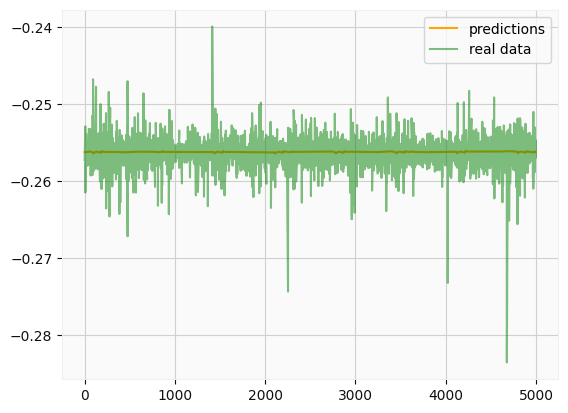

In [24]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [25]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

In [26]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

OHLCV = ['open', 'high', 'low', 'close', 'volume']

class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [27]:
class CommInfoFractional(bt.CommissionInfo):
    """
    Allow fractions of assets/currencies
    """
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


class MLStrategy(bt.Strategy):
    params = (('n_positions', 25),
              ('min_positions', 20),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            #print(data.datetime.date(),today)
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
                
        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

## Back-testing buy or do nothing, i.e. up-only

In [28]:
from time import time

target = "LogReturns"

cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

OHLCV = ['open', 'high', 'low', 'close', 'volume']
OHLCV_cap = list(map(lambda x:x.capitalize() ,OHLCV))

if target == "Close":
  up_or_down = list(map(lambda x: 1. if x> 0 else -1. ,  
                        tu.log_return(pd.Series(np.array(
                            btc_model.preds.squeeze())),periods=-1)))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. ,  
                             tu.log_return(pd.Series(
                                 np.array(btc_model.y_test.squeeze())),periods=-1)))

elif target == "LogReturns":
  up_or_down = list(map(lambda x: 1. if x> 0 else -1. , btc_model.preds))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. , btc_model.y_test))

df_updown_true =  tu.merge_true_preds(can_btc.candles,up_or_down,period = 1)
df_updown_true_test = tu.merge_true_preds(can_btc.candles,up_or_down_test, period = 0)
df_preds_true_ohlcv = tu.merge_true_preds(can_btc.candles,preds,period = 1,
                                          columns = OHLCV_cap).reset_index().rename(
                                          columns = {i:j for i,j in 
                                                     zip(["Date","Pred Close"] + 
                                                OHLCV_cap,["date","predicted"] +
                                                OHLCV)})
                                          
df_preds_true_ohlcv["ticker"] = "BTCUSD"
df_updown_true["ticker"] ="BTCUSD"      
df_updown_true.index.name="date"
df_updown_true = df_updown_true.reset_index().set_index(["ticker","date"])

data = df_preds_true_ohlcv.set_index(['ticker','date'])
first_column = data.pop('predicted')
data.insert(0, 'predicted', df_updown_true["Pred Close"])
data=data.dropna()

idx = pd.IndexSlice
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)


cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
                    verbose=True, log_file='bt_log.csv')
start = time()
# use the fractional scheme if requested
cerebro.broker.addcommissioninfo(CommInfoFractional())
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 9,892.47
Duration: 00:00:24


In [29]:
from sklearn.metrics import confusion_matrix

df_data = pd.concat([df_updown_true.droplevel("ticker").iloc[:,-1].rename(
          "Predicted"), df_updown_true_test.iloc[:,-1].rename("Test")],axis=1)

confusion_matrix(df_data["Test"].dropna(), df_data["Predicted"].dropna())

array([[  46, 2433],
       [  40, 2477]])

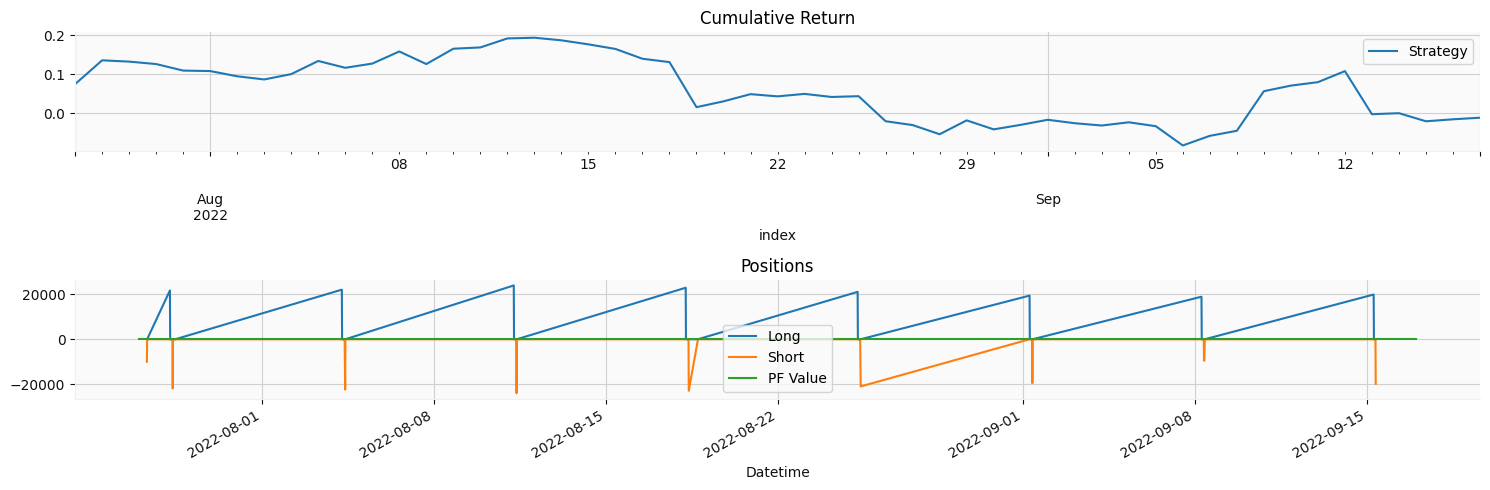

In [30]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
daily_tx = transactions.groupby(level=0)

longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

fig, axes = plt.subplots(nrows=2, figsize=(15, 5))

df = returns.to_frame('Strategy')#.join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

## Train for more epochs

In [31]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [32]:
btc_model.sats2train(model_name, save_model = False, epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 2/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 4/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 6/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/100
11/11 [==============================] - 1s 89ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 9/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/100
11/11 [==============================] - 1s 91ms/step - loss: 0.0027 - val_loss: 0.00

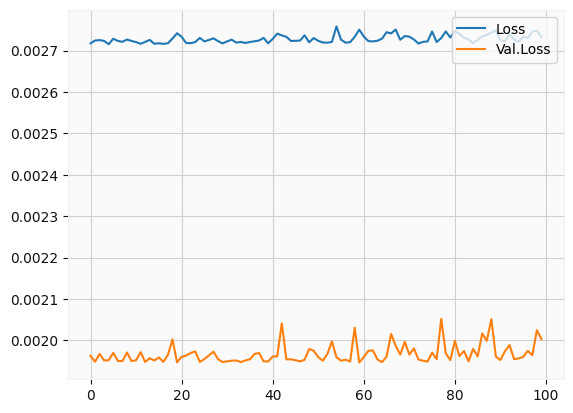

In [33]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [34]:
btc_model.sats2pred(predict_on_test = True)

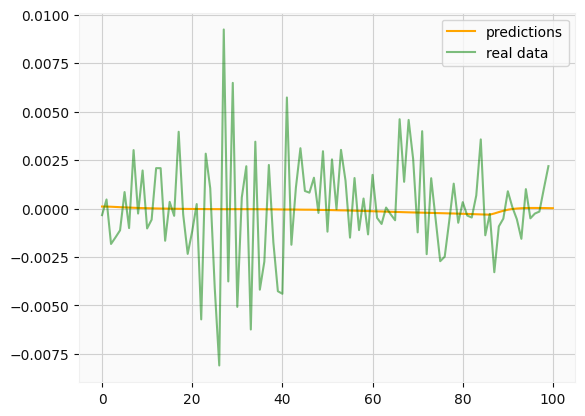

In [35]:
plt.plot(btc_model.preds[-101:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [36]:
target = "LogReturns"

cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000

cerebro.broker.setcash(cash)

OHLCV = ['open', 'high', 'low', 'close', 'volume']
OHLCV_cap = list(map(lambda x:x.capitalize() ,OHLCV))

if target == "Close":
  up_or_down = list(map(lambda x: 1. if x> 0 else -1. ,  
                        tu.log_return(pd.Series(np.array(
                            btc_model.preds.squeeze())),periods=-1)))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. ,  
                             tu.log_return(pd.Series(
                                 np.array(btc_model.y_test.squeeze())),periods=-1)))

elif target == "LogReturns":
  up_or_down = list(map(lambda x: 1. if x> 0 else -1. , btc_model.preds))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. , btc_model.y_test))

df_updown_true =  tu.merge_true_preds(can_btc.candles,up_or_down,period = 1)
df_updown_true_test = tu.merge_true_preds(can_btc.candles,up_or_down_test, period = 0)
df_preds_true_ohlcv = tu.merge_true_preds(can_btc.candles,preds,period = 1,
                                          columns = OHLCV_cap).reset_index().rename(
                                          columns = {i:j for i,j in 
                                                     zip(["Date","Pred Close"] + 
                                                OHLCV_cap,["date","predicted"] +
                                                OHLCV)})
                                          
df_preds_true_ohlcv["ticker"] = "BTCUSD"
df_updown_true["ticker"] ="BTCUSD"      
df_updown_true.index.name="date"
df_updown_true = df_updown_true.reset_index().set_index(["ticker","date"])

data = df_preds_true_ohlcv.set_index(['ticker','date'])
first_column = data.pop('predicted')
data.insert(0, 'predicted', df_updown_true["Pred Close"])
data=data.dropna()

idx = pd.IndexSlice
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)


cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
                    verbose=True, log_file='bt_log.csv')
start = time()
# use the fractional scheme if requested
cerebro.broker.addcommissioninfo(CommInfoFractional())
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 9,294.80
Duration: 00:00:29


In [37]:
df_data = pd.concat([df_updown_true.droplevel("ticker").iloc[:,-1].rename(
          "Predicted"), df_updown_true_test.iloc[:,-1].rename("Test")],axis=1)

confusion_matrix(df_data["Test"].dropna(), df_data["Predicted"].dropna())

array([[1550,  929],
       [1628,  889]])

In [38]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2022-07-27 07:45:00+00:00,0.468282,21353.45,0,BTCUSD,-9999.433379
2022-07-27 08:00:00+00:00,0.000027,21346.11,0,BTCUSD,-0.566588
2022-07-28 06:15:00+00:00,-0.936617,23158.94,0,BTCUSD,21691.052649
2022-07-28 06:30:00+00:00,0.000033,23159.75,0,BTCUSD,-0.758660
2022-07-28 06:45:00+00:00,0.000174,23165.29,0,BTCUSD,-4.036750
...,...,...,...,...,...
2022-09-15 07:30:00+00:00,0.000216,20220.15,0,BTCUSD,-4.368023
2022-09-15 07:45:00+00:00,-0.002921,20158.82,0,BTCUSD,58.885476
2022-09-15 08:00:00+00:00,0.002158,20204.23,0,BTCUSD,-43.600841


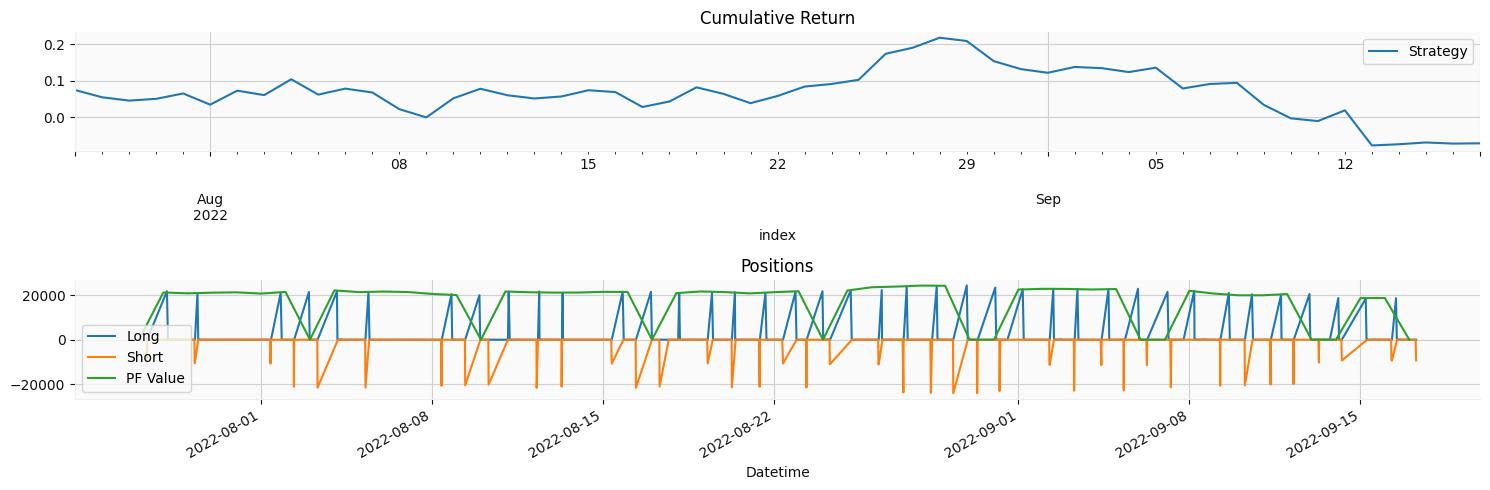

In [39]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
daily_tx = transactions.groupby(level=0)

longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

fig, axes = plt.subplots(nrows=2, figsize=(15, 5))

df = returns.to_frame('Strategy')#.join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

In [40]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Initial time 2022-07-27 07:30:00
Final time 2022-09-17 08:00:00
Fee: 0.025
----------------------
Buy      4992 ( 2515 ok 2477 ko )
Avg PCT gain: 1.0019212117598335
Avg PCT loss: 0.9980276569286349
Wins  PCT   0.5038060897435898
Avg PCT Gain.    1.0019212117598335
No-op    0
Wallet   -6856.289000000012
Drawback -1558.081999999998
Kelly Fraction    0.009540433100152512
Total earned -6856.289000000012


/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:432: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index, wallet_hist_df.iloc[:, 1])


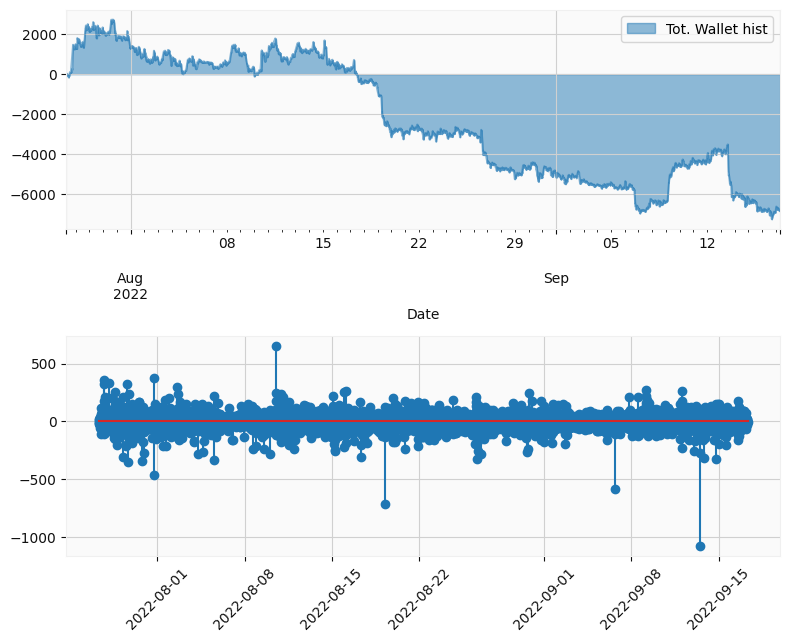

In [41]:
df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)

wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 2,
                                                     long_short="long", fee=0.025, cutoff_long=20., cutoff_short=20.0)
s2b.show_backtest_results(wallet, wallet_hist_df)

In [42]:
df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tu.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tu.log_return(df_pred_exp["Predicted"],periods=-1)


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


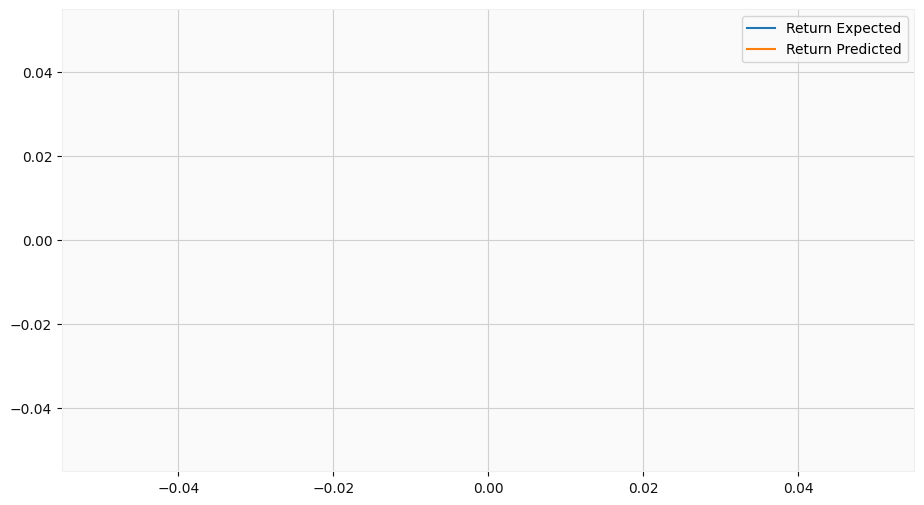

In [43]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)